In [1]:
import torch
import lovely_tensors as lt
lt.monkey_patch()

## Notebook objectives
1. Investigate convergence of various optimizers.

# Define the neural net model

PyTorch has a built-in differentiation library `autograd` because of which we do not have to explicitly write a `backward` method. Getting rid of it..

In [2]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
input_dim = 10
hidden_dim = 5
output_dim = 1
n_samples = 25

# Creating a sample train, val and test dataset

In [4]:
g = torch.Generator().manual_seed(42)
g2 = torch.Generator().manual_seed(2145521414)
g3 = torch.Generator().manual_seed(4544313143143)

train_X = torch.randn((n_samples, input_dim), generator=g)
train_y = torch.randn((n_samples, output_dim), generator=g)
train_y = torch.where(train_y > 0, 1, 0).squeeze()

val_X = torch.randn((n_samples, input_dim), generator=g2)
val_y = torch.randn((n_samples, output_dim), generator=g2)
val_y = torch.where(val_y > 0, 1, 0).squeeze()

test_X = torch.randn((n_samples, input_dim), generator=g3)
test_y = torch.randn((n_samples, output_dim), generator=g3)
test_y = torch.where(test_y > 0, 1, 0).squeeze()

# print(train_X, train_y)


# Run the forward pass

Let's go with the previous optimizer and try a few more!

In [5]:
# from torchinfo import summary

# model = NeuralNet(input_dim=10, hidden_dim=5, output_dim=1)
# summary(model, input_size=(1, 10))

In [6]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

torch.manual_seed(42)
clf = NeuralNet(input_dim, hidden_dim, output_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.01)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = criterion(y_pred.squeeze(), train_y.float())

    # reset the gradients
    optimizer.zero_grad()
    
    # backward pass
    loss.backward()

    # update the weights by a small amount
    optimizer.step()

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)

    val_loss = criterion(val_preds.squeeze(), val_y.float())
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch:   0 | train_loss:  0.406586 | val_loss:  0.499383
 epoch:   1 | train_loss:  0.397242 | val_loss:  0.490152
 epoch:   2 | train_loss:  0.388333 | val_loss:  0.481407
 epoch:   3 | train_loss:  0.379840 | val_loss:  0.473127
 epoch:   4 | train_loss:  0.371743 | val_loss:  0.465288
 epoch:   5 | train_loss:  0.364022 | val_loss:  0.457870
 epoch:   6 | train_loss:  0.356661 | val_loss:  0.450853
 epoch:   7 | train_loss:  0.349643 | val_loss:  0.444219
 epoch:   8 | train_loss:  0.342951 | val_loss:  0.437946
 epoch:   9 | train_loss:  0.336569 | val_loss:  0.432014
 epoch:  10 | train_loss:  0.330483 | val_loss:  0.426411
 epoch:  11 | train_loss:  0.324679 | val_loss:  0.421122
 epoch:  12 | train_loss:  0.319144 | val_loss:  0.416132
 epoch:  13 | train_loss:  0.313864 | val_loss:  0.411426
 epoch:  14 | train_loss:  0.308827 | val_loss:  0.406989
 epoch:  15 | train_loss:  0.304022 | val_loss:  0.402807
 epoch:  16 | train_loss:  0.299437 | val_loss:  0.398870
 epoch:  17 | 

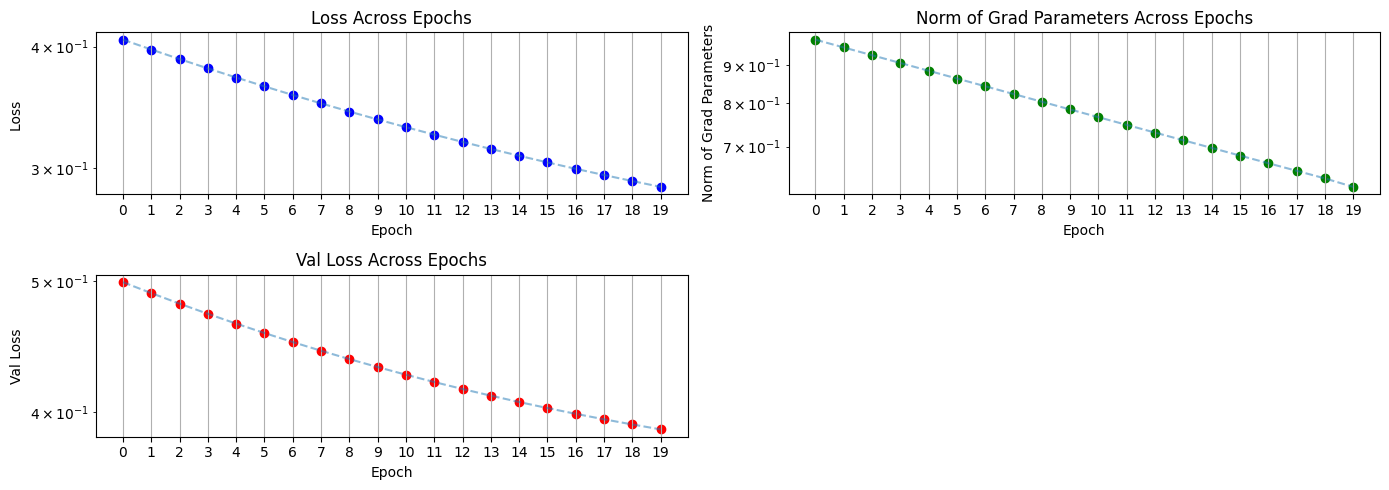

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2, 2, figsize=(14, 5))

epochs = list(range(n_epochs))

# Plot means
axes[0, 0].scatter(epochs, losses, color='blue')
axes[0, 0].plot(epochs, losses, linestyle='dashed', alpha=0.5)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss ')
axes[0, 0].set_title('Loss Across Epochs')
axes[0, 0].set_xticks(epochs)
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True)

# Plot norms (gradient norms) in axes[0, 1]
axes[0, 1].scatter(epochs, g_norms, color='green')
axes[0, 1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Norm of Grad Parameters')
axes[0, 1].set_title('Norm of Grad Parameters Across Epochs')
axes[0, 1].set_xticks(epochs)
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True)

# Plot validation loss in axes[1, 0]
axes[1, 0].scatter(epochs, val_losses, color='red')
axes[1, 0].plot(epochs, val_losses, linestyle='dashed', alpha=0.5)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Val Loss')
axes[1, 0].set_title('Val Loss Across Epochs')
axes[1, 0].set_xticks(epochs)
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

# Remove the 4th plot (axes[1, 1])
fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

In [8]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

torch.manual_seed(42)
clf = NeuralNet(input_dim, hidden_dim, output_dim)

criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(clf.parameters(), lr=0.01)
optimizer = torch.optim.Adam(clf.parameters(), lr=0.001)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = criterion(y_pred.squeeze(), train_y.float())

    # reset the gradients
    optimizer.zero_grad()
    
    # backward pass
    loss.backward()

    # update the weights by a small amount
    optimizer.step()

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)

    val_loss = criterion(val_preds.squeeze(), val_y.float())
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:03d}/{n_epochs:03d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch: 000/020 | train_loss:  0.406586 | val_loss:  0.506750
 epoch: 001/020 | train_loss:  0.403257 | val_loss:  0.504418
 epoch: 002/020 | train_loss:  0.399959 | val_loss:  0.502111
 epoch: 003/020 | train_loss:  0.396690 | val_loss:  0.499818
 epoch: 004/020 | train_loss:  0.393453 | val_loss:  0.497558
 epoch: 005/020 | train_loss:  0.390248 | val_loss:  0.495334
 epoch: 006/020 | train_loss:  0.387075 | val_loss:  0.493150
 epoch: 007/020 | train_loss:  0.383935 | val_loss:  0.491009
 epoch: 008/020 | train_loss:  0.380828 | val_loss:  0.488912
 epoch: 009/020 | train_loss:  0.377754 | val_loss:  0.486859
 epoch: 010/020 | train_loss:  0.374716 | val_loss:  0.484849
 epoch: 011/020 | train_loss:  0.371710 | val_loss:  0.482883
 epoch: 012/020 | train_loss:  0.368737 | val_loss:  0.480959
 epoch: 013/020 | train_loss:  0.365796 | val_loss:  0.479077
 epoch: 014/020 | train_loss:  0.362887 | val_loss:  0.477236
 epoch: 015/020 | train_loss:  0.360007 | val_loss:  0.475435
 epoch: 

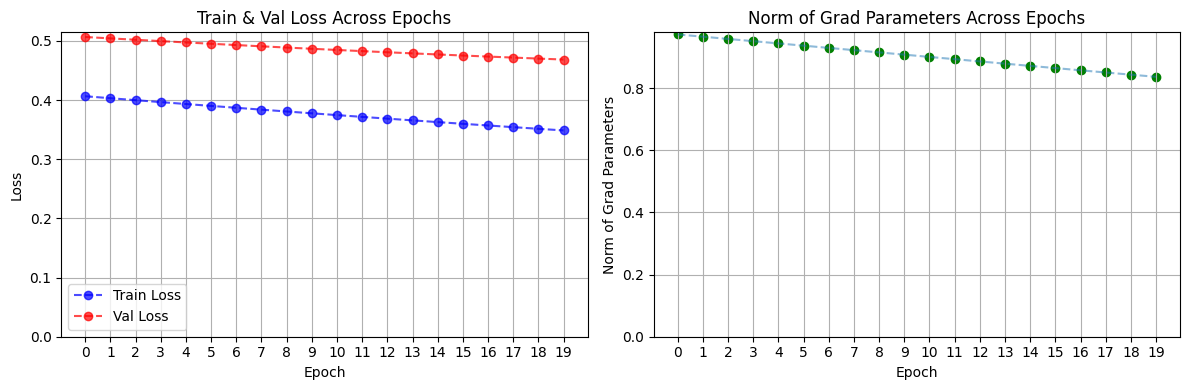

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = list(range(n_epochs))

# Plot train and val loss on the same plot
axes[0].plot(epochs, losses, label='Train Loss', color='blue', marker='o', linestyle='dashed', alpha=0.7)
axes[0].plot(epochs, val_losses, label='Val Loss', color='red', marker='o', linestyle='dashed', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train & Val Loss Across Epochs')
axes[0].set_xticks(epochs)
axes[0].set_ylim(bottom=0)  # Start y-axis from zero
axes[0].grid(True)
axes[0].legend()

# Plot gradient norms
axes[1].scatter(epochs, g_norms, color='green')
axes[1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Norm of Grad Parameters')
axes[1].set_title('Norm of Grad Parameters Across Epochs')
axes[1].set_xticks(epochs)
axes[1].set_ylim(bottom=0)  # Start y-axis from zero
axes[1].grid(True)

plt.tight_layout()
plt.show()


Even though the loss values in this specific experiment are better for SGD, empirically, from many many experiments from the OSS community, Adam is a much better optimizer for large scale training workloads.